In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! pip install opendatasets

In [6]:
!pip install git+https://github.com/cristinekalinski/robustness.git

  Cloning https://github.com/cristinekalinski/robustness.git to /tmp/pip-req-build-l1k2w2j0
  Running command git clone --filter=blob:none --quiet https://github.com/cristinekalinski/robustness.git /tmp/pip-req-build-l1k2w2j0
  Resolved https://github.com/cristinekalinski/robustness.git to commit 21df66a754c2504612a81d88bba09f96eb13c7db
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cu

In [7]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000/data")

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000


100%|██████████| 5.20G/5.20G [01:04<00:00, 86.0MB/s]


In [8]:
import os
from glob import glob
import pandas as pd
from PIL import Image
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.utils import resample
import numpy as np


In [9]:
data_dir = '/content/skin-cancer-mnist-ham10000'
print(os.listdir(data_dir))


all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}



metadata_filepath = os.path.join(data_dir, 'HAM10000_metadata.csv')
metadata_df = pd.read_csv(metadata_filepath)
metadata_df['path'] = metadata_df['image_id'].map(imageid_path_dict.get)
metadata_df['cell_type'] = metadata_df['dx'].map(lesion_type_dict.get)


def is_valid_image_file(filename):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']
    if os.path.splitext(filename)[1].lower() not in valid_extensions:
        print(f"Invalid image file extension \"{filename}\". Skipping this file...")
        return False
    try:
        with Image.open(filename) as img:
            img.verify()
            return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image file {filename}: {e}")
        return False

def copy_images_to_formatted_structure(metadata_df, new_dir):
    classes = metadata_df['dx'].unique()
    phases = ['train', 'val']

    for phase in phases:
        phase_dir = os.path.join(new_dir, phase)
        for class_label in classes:
            os.makedirs(os.path.join(phase_dir, class_label), exist_ok=True)

    train_df = metadata_df.sample(frac=0.8, random_state=123)
    val_df = metadata_df.drop(train_df.index)

    def copy_files(df, phase):
        for _, row in df.iterrows():
            src_file_path = row['path']
            if is_valid_image_file(src_file_path):
                dst_file_path = os.path.join(new_dir, phase, row['dx'], os.path.basename(src_file_path))
                shutil.copy(src_file_path, dst_file_path)

    copy_files(train_df, 'train')
    copy_files(val_df, 'val')

# new directory for the formatted dataset
new_dataset_dir = '/content/formatted_skin_cancer_data'
copy_images_to_formatted_structure(metadata_df, new_dataset_dir)



['ham10000_images_part_1', 'HAM10000_images_part_1', 'ham10000_images_part_2', 'hmnist_8_8_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_RGB.csv', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv']


In [ ]:
# new_dataset_dir = '/content/drive/My Drive/BAI/SkinCancer_project/formatted_skin_cancer_data'
# copy_images_to_formatted_structure(metadata_df, new_dataset_dir)

<ipython-input-10-183f4280b033>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=metadata_df, x='dx', palette='bright')


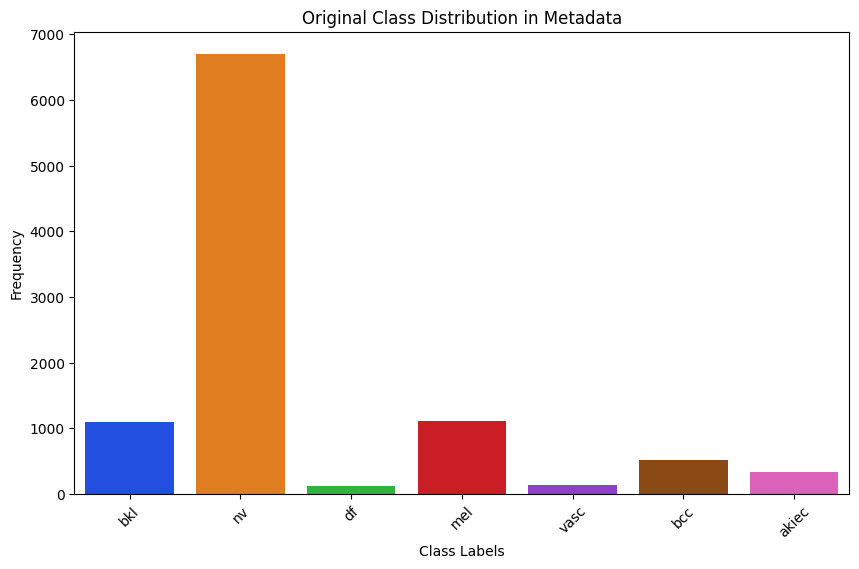

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=metadata_df, x='dx', palette='bright')
plt.title('Original Class Distribution in Metadata')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

metadata_df['dx'].value_counts()

In [11]:
### Augmenting for class imbalance
augment_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

def augment_class_images(data_dir, class_label, n_required, augment=True):
    class_path = os.path.join(data_dir, class_label)
    image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.jpg')]
    n_current = len(image_files)
    n_needed = n_required - n_current

    if augment and n_needed > 0:
        while n_needed > 0:
            for img_file in image_files:
                if n_needed <= 0:
                    break
                img = Image.open(img_file)
                img_transformed = augment_transforms(img)
                new_filename = os.path.splitext(img_file)[0] + f'_aug_{n_needed}.jpg'
                img_transformed.save(new_filename)
                n_needed -= 1
    elif not augment and n_needed < 0:
        # downsampling
        to_remove = np.random.choice(image_files, size=abs(n_needed), replace=False)
        for f in to_remove:
            os.remove(f)

# where the training images are stored
data_dir = '/content/formatted_skin_cancer_data/train'

augment_class_images(data_dir, 'akiec', 1000)
augment_class_images(data_dir, 'vasc', 1000)
augment_class_images(data_dir, 'df', 1000)
augment_class_images(data_dir, 'bkl', 1000)
augment_class_images(data_dir, 'bcc', 1000)
augment_class_images(data_dir, 'mel', 1000)
augment_class_images(data_dir, 'nv', 3000, augment=False)


<ipython-input-12-94d8a1a77867>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts_df, x='Class', y='Frequency', palette='bright')


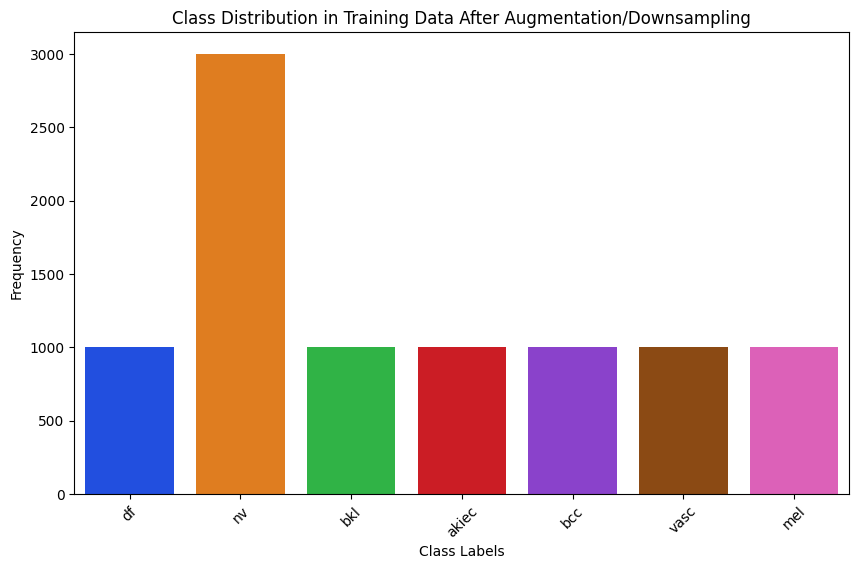

{'df': 1000,
 'nv': 3000,
 'bkl': 1000,
 'akiec': 1000,
 'bcc': 1000,
 'vasc': 1000,
 'mel': 1000}

In [12]:
train_dir = '/content/formatted_skin_cancer_data/train'

class_labels = os.listdir(train_dir)
class_counts = {}
for label in class_labels:
    class_path = os.path.join(train_dir, label)
    class_counts[label] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])

counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(data=counts_df, x='Class', y='Frequency', palette='bright')
plt.title('Class Distribution in Training Data After Augmentation/Downsampling')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show();
class_counts

<ipython-input-13-fae585318d75>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=val_counts_df, x='Class', y='Frequency', palette='bright')


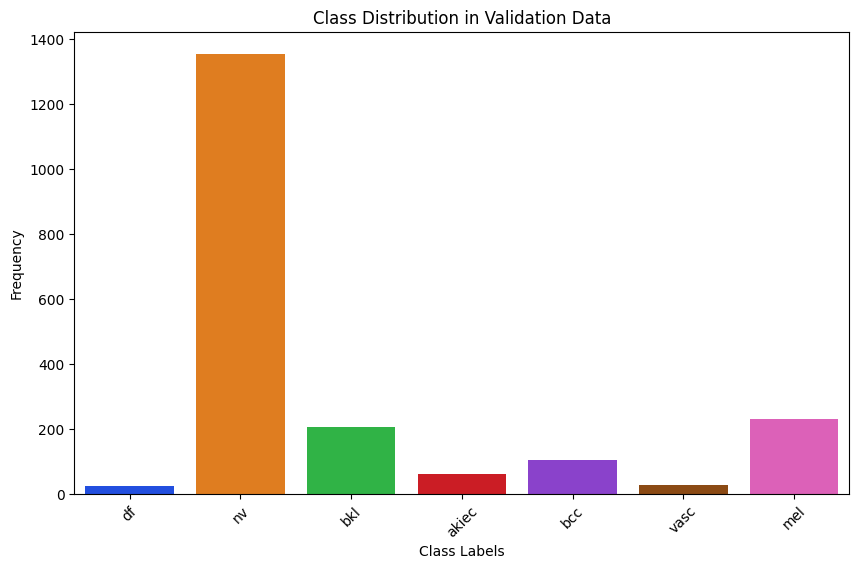

{'df': 24,
 'nv': 1353,
 'bkl': 204,
 'akiec': 62,
 'bcc': 104,
 'vasc': 26,
 'mel': 230}

In [13]:
val_dir = '/content/formatted_skin_cancer_data/val'

val_class_labels = os.listdir(val_dir)

val_class_counts = {}
for label in val_class_labels:
    class_path = os.path.join(val_dir, label)
    val_class_counts[label] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])

val_counts_df = pd.DataFrame(list(val_class_counts.items()), columns=['Class', 'Frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(data=val_counts_df, x='Class', y='Frequency', palette='bright')
plt.title('Class Distribution in Validation Data')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
val_class_counts

In [14]:
import torch as ch
from torchvision import transforms
from robustness.datasets import DataSet
from robustness import imagenet_models


class SkinCancerDatasetRobust(DataSet):
    def __init__(self, data_path='/content/formatted_skin_cancer_data'):

        #### standard imagenet transforms ####
        transform_train = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])

        transform_test = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])

        num_classes = 7

        super(SkinCancerDatasetRobust, self).__init__(
            'skin_cancer', data_path, num_classes=num_classes,
            mean=ch.tensor([0.7630389, 0.5456449, 0.57004166]),
            std=ch.tensor([0.14092816, 0.15261336, 0.16997123]),
            custom_class=None, label_mapping=None,
            transform_train=transform_train, transform_test=transform_test
        )

    def get_model(self, arch, pretrained=True):
        return imagenet_models.__dict__[arch](num_classes=self.num_classes, pretrained=pretrained)


In [15]:
from robustness.datasets import DATASETS, ImageNet
from robustness.model_utils import make_and_restore_model
from robustness.train import train_model
from robustness.defaults import check_and_fill_args
from robustness.tools import constants, helpers
from robustness import defaults

from cox import utils
from cox import store

import torch as ch
from argparse import ArgumentParser
import os


train_kwargs = {
    'dataset': SkinCancerDatasetRobust(),
    'arch': 'resnet50',
    'out_dir': "/content/train_out",
    'lr': 0.01,
    'adv_train': 1,
    'constraint': '2',
    'eps': 3,
    'attack_lr': 1.5,
    'attack_steps': 20,
    'epochs': 6,
    'batch_size': 32,
    'weight_decay': 1e-4,
    'step_lr': 50,
    'workers': 2,
}

args = utils.Parameters(train_kwargs)

assert args.dataset is not None, "Must provide a dataset"
ds_class_for_defaults = DATASETS['imagenet']

args = check_and_fill_args(args, defaults.TRAINING_ARGS, ds_class_for_defaults)
if args.adv_train or args.adv_eval:
    args = check_and_fill_args(args, defaults.PGD_ARGS, ds_class_for_defaults)
args = check_and_fill_args(args, defaults.MODEL_LOADER_ARGS, ds_class_for_defaults)


/usr/local/lib/python3.10/dist-packages/robustness/train.py:24: UserWarning: Could not import amp.
  warnings.warn('Could not import amp.')


In [ ]:
#!wget https://www.dropbox.com/s/knf4uimlqsi1yz8/imagenet_l2_3_0.pt

In [16]:
### Training loop, only run if training again


ds = SkinCancerDatasetRobust('/content/formatted_skin_cancer_data')

train_loader, val_loader = ds.make_loaders(args.workers,
              args.batch_size, data_aug=bool(args.data_aug))


train_loader = helpers.DataPrefetcher(train_loader)
val_loader = helpers.DataPrefetcher(val_loader)

# Get a "model" that is associated with the dataset. Note that this is "model"
# is a wrapper around some resnet50 object together with various functions that
# enable adversarial training
# model, _ = make_and_restore_model(arch='resnet50', dataset=ImageNet("./"), resume_path='/content/imagenet_l2_3_0.pt')
# model.model.fc = ch.nn.Linear(in_features=2048, out_features=ds.num_classes, bias=True)
# model, _ = make_and_restore_model(arch=model.model, dataset=ds, add_custom_forward=True)

# my_store = store.Store(args.out_dir, args.exp_name)
# args_dict = args.as_dict() if isinstance(args, utils.Parameters) else vars(args)
# schema = store.schema_from_dict(args_dict)
# my_store.add_table('metadata', schema)
# my_store['metadata'].append_row(args_dict)

==> Preparing dataset skin_cancer..


In [ ]:
# Train the model!
# Note that it evaluates on the "val" set twice for each epoch: once to get
# clean accuracy (NatPrec1), and once to get accuracy on adversarial examples (AdvPrec1)
# Adjust the number of epochs, learning rate as per your model's and dataset's requirement.


# model = train_model(args, model, (train_loader, val_loader), store=my_store)


  0%|          | 0/282 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train Epoch:0 | Loss 1.3970 | AdvPrec1 44.822 | AdvPrec5 93.144 | Reg term: 0.0 ||: 100%|██████████| 282/282 [20:52<00:00,  4.44s/it]
Val Epoch:0 | Loss 0.7159 | NatPrec1 74.239 | NatPrec5 99.051 | Reg term: 0.0 ||: 100%|██████████| 63/63 [00:19<00:00,  3.29it/s]
Val Epoch:0 | Loss 0.9163 | AdvPrec1 64.453 | AdvPrec5 97.903 | Reg term: 0.0 ||: 100%|██████████| 63/63 [04:27<00:00,  4.25s/it]
  0%|          | 0/282 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train Epoch:1 | Loss 1.1623 | AdvPrec1 53.078 | AdvPrec5 97.700 

In [36]:
### Using previously trained model
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import torch
from robustness.model_utils import make_and_restore_model
from robustness.datasets import ImageNet


ds = SkinCancerDatasetRobust('/content/formatted_skin_cancer_data')

model, _ = make_and_restore_model(arch='resnet50', dataset=ImageNet("./"), resume_path=None)
model.model.fc = torch.nn.Linear(in_features=2048, out_features=ds.num_classes, bias=True)
model, _ = make_and_restore_model(arch=model.model, dataset=ds, add_custom_forward=True)


Mounted at /content/drive


In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:0


In [38]:
checkpoint_path = '/content/drive/MyDrive/train_out/d77ae870-daca-4988-acab-9842f0ccaf9b/checkpoint.pt.latest'
checkpoint = torch.load(checkpoint_path)

In [39]:
checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())



dict_keys(['model', 'optimizer', 'schedule', 'epoch', 'amp', 'adv_prec1'])


In [40]:
checkpoint = torch.load(checkpoint_path, map_location=device)
state_dict = checkpoint['model']
new_state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}
model.load_state_dict(new_state_dict)


<All keys matched successfully>

In [41]:
from sklearn.metrics import confusion_matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[ 24  20   0   0   1   0  17]
 [ 14  52   0   0   3   5  30]
 [ 35  36   0   1  37  25  70]
 [  2   7   0   2   1   1  11]
 [ 18  11   0   0  73  55  73]
 [ 36  51   0   3  73 385 805]
 [  1   1   0   0   0   2  22]]


Class names in order: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


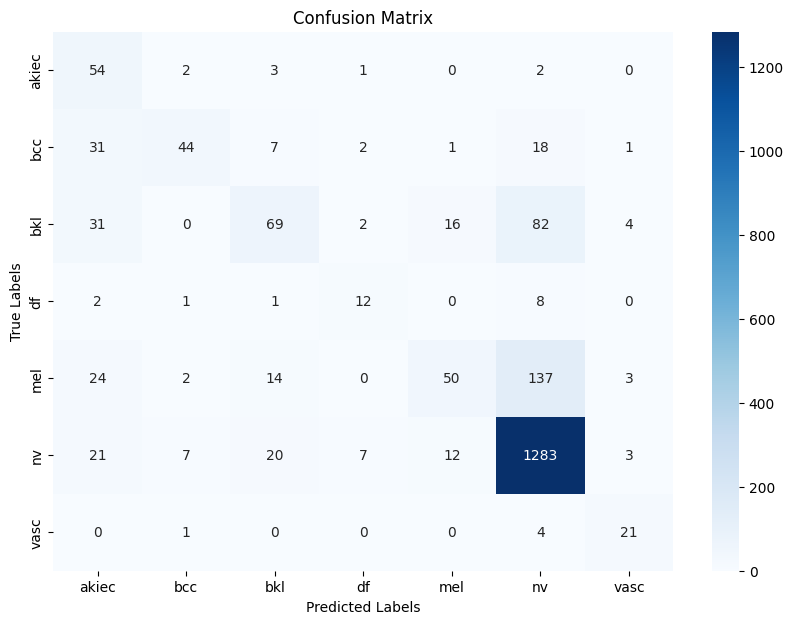

In [23]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder('/content/formatted_skin_cancer_data')
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print("Class names in order:", class_names)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef

y_true = all_labels
y_pred = all_preds

print("Precision (None):", precision_score(y_true, y_pred, average=None))
print("Precision (Weighted):", precision_score(y_true, y_pred, average='weighted'))

print("Recall (None):", recall_score(y_true, y_pred, average=None))
print("Recall (Weighted):", recall_score(y_true, y_pred, average='weighted'))

print("F1 Score (None):", f1_score(y_true, y_pred, average=None))
print("F1 Score (Weighted):", f1_score(y_true, y_pred, average='weighted'))


Precision (None): [0.33128834 0.77192982 0.60526316 0.5        0.63291139 0.83637549
 0.65625   ]
Precision (Weighted): 0.764125022478561
Recall (None): [0.87096774 0.42307692 0.33823529 0.5        0.2173913  0.94826312
 0.80769231]
Recall (Weighted): 0.7653519720419371
F1 Score (None): [0.48       0.54658385 0.43396226 0.5        0.3236246  0.88881192
 0.72413793]
F1 Score (Weighted): 0.7403678418358874


==> Preparing dataset skin_cancer..


Current loss: 0.0001698055857559666: 100%|██████████| 50/50 [00:03<00:00, 13.31it/s]


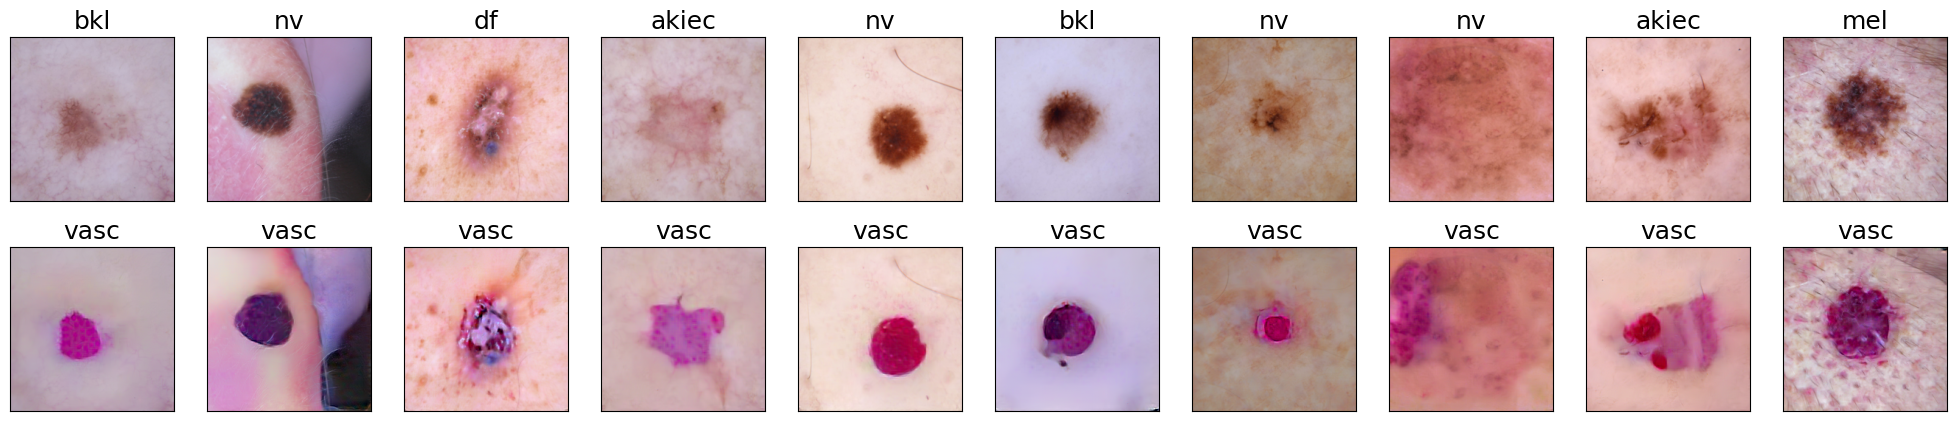

In [49]:
from robustness.tools.vis_tools import show_image_row
from robustness.tools.label_maps import CLASS_DICT


ATTACK_EPS = 30
ATTACK_STEPSIZE = 0.5
ATTACK_STEPS = 50
NUM_WORKERS = 2
BATCH_SIZE = 10

kwargs = {
    'constraint': '2',
    'eps': ATTACK_EPS,
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'targeted': True,
    'do_tqdm': True
}


train_loader, val_loader = ds.make_loaders(workers=NUM_WORKERS, batch_size=BATCH_SIZE, data_aug=False)


device = ch.device("cuda" if ch.cuda.is_available() else "cpu")


im, label = next(iter(val_loader))
im = im.to(device)
label = label.to(device)



CLASS_DICT = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

target_class_label = 'vasc'
target_class_index = {v: k for k, v in CLASS_DICT.items()}[target_class_label]


targ = target_class_index * torch.ones_like(label, dtype=torch.long)



_, im_adv = model(im, targ, make_adv=True, **kwargs)


pred, _ = model(im_adv)
label_pred = ch.argmax(pred, dim=1)



show_image_row([im.cpu(), im_adv.cpu()],
               tlist=[[CLASS_DICT[int(t)] for t in l] for l in [label, label_pred]],
               fontsize=18,
               filename='./adversarial_example_skin_cancer.png')



Current loss: 0.07481537759304047: 100%|██████████| 50/50 [00:05<00:00,  9.82it/s]


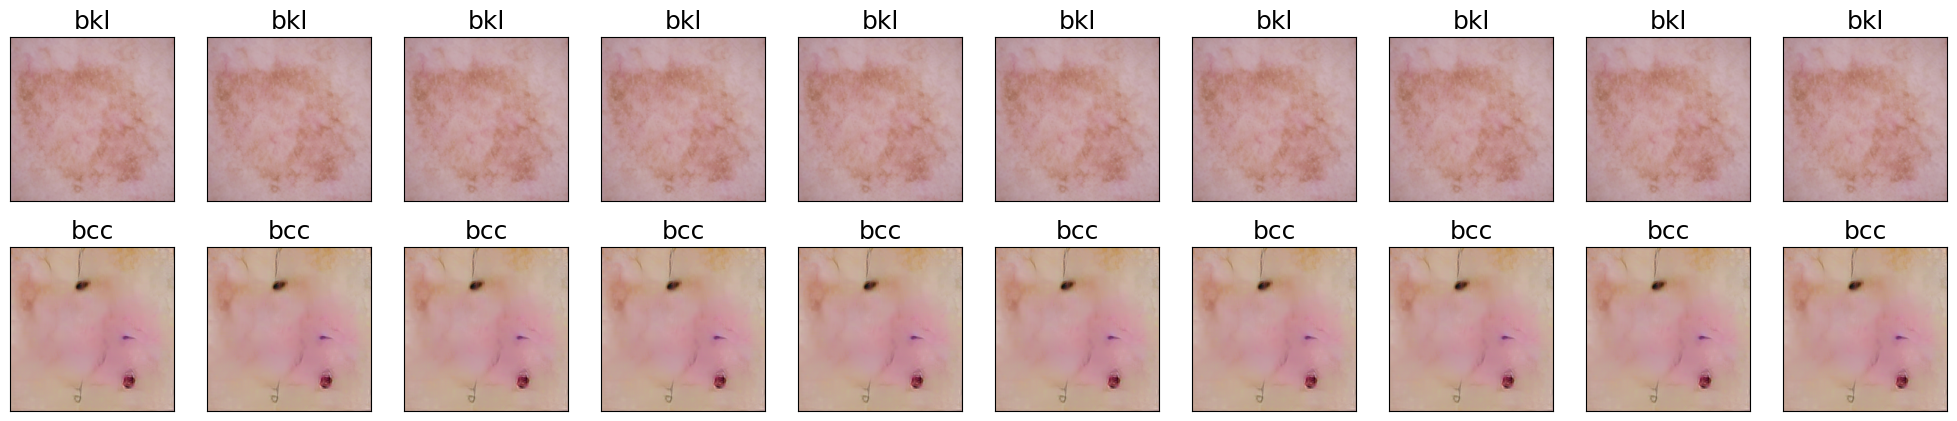

In [50]:
from torch.utils.data import DataLoader, Dataset

starting_class_label = 'bkl'
target_class_label = 'bcc'

starting_class_index = {v: k for k, v in CLASS_DICT.items()}[starting_class_label]
target_class_index = {v: k for k, v in CLASS_DICT.items()}[target_class_label]

class SpecificClassFilter(Dataset):
    def __init__(self, dataset, class_index):
        self.dataset = dataset
        self.class_index = class_index

    def __len__(self):
        return len([1 for _, label in self.dataset if label == self.class_index])

    def __getitem__(self, idx):
        while True:
            image, label = self.dataset[idx]
            if label == self.class_index:
                return image, label
            idx = (idx + 1) % len(self.dataset)

filtered_dataset = SpecificClassFilter(val_loader.dataset, starting_class_index)
filtered_loader = DataLoader(filtered_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
im, label = next(iter(filtered_loader))
im = im.to(device)
label = label.to(device)

targ = target_class_index * torch.ones_like(label, dtype=torch.long)

_, im_adv = model(im, targ, make_adv=True, **kwargs)

pred, _ = model(im_adv)
label_pred = torch.argmax(pred, dim=1)

show_image_row([im.cpu(), im_adv.cpu()],
               tlist=[[CLASS_DICT[int(t.item())] for t in l] for l in [label, label_pred]],
               fontsize=18,
               filename='./targeted_adversarial_example.png')


Current loss: 0.02624824270606041: 100%|██████████| 50/50 [00:02<00:00, 19.60it/s]


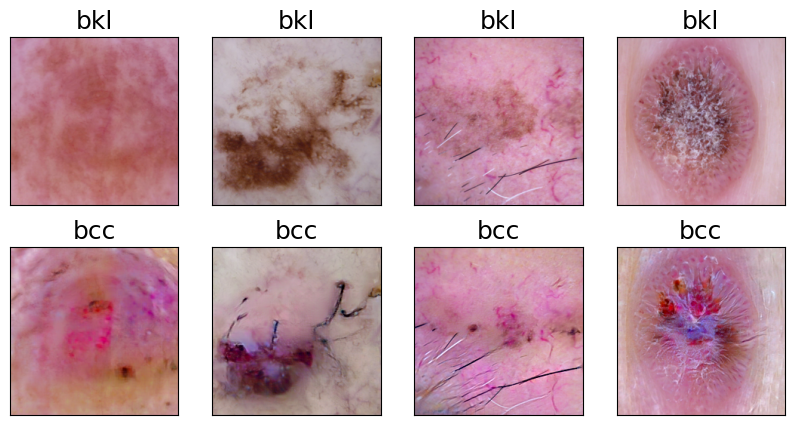

In [51]:
from torch.utils.data import DataLoader, Subset

# Assuming these class labels and dictionary setup
CLASS_DICT = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
start_class_label = 'bkl'
target_class_label = 'bcc'

# Convert labels from class names to indices
start_class_index = {v: k for k, v in CLASS_DICT.items()}[start_class_label]
target_class_index = {v: k for k, v in CLASS_DICT.items()}[target_class_label]

# Create a subset loader that only includes images from the starting class
def filter_loader(loader, class_index):
    for images, labels in loader:
        mask = labels == class_index
        if mask.any():
            yield images[mask], labels[mask]

# Create filtered loaders for the specific class
filtered_loader = filter_loader(val_loader, start_class_index)

# Get a single batch of images and labels
im, label = next(iter(filtered_loader))
im = im.to(device)
label = label.to(device)

# Create a target tensor where all elements are the target class index
targ = torch.full_like(label, target_class_index, dtype=torch.long)

# Generate adversarial images
_, im_adv = model(im, targ, make_adv=True, **kwargs)

# Predict labels for adversarial images
pred, _ = model(im_adv)
label_pred = ch.argmax(pred, dim=1)

# Visualization of the original and adversarial images
show_image_row([im.cpu(), im_adv.cpu()],
               tlist=[[CLASS_DICT[int(t)] for t in l] for l in [label, label_pred]],
               fontsize=18,
               filename='./adversarial_example_specific_class.png')


# Grad-CAM stuff

In [27]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder('/content/formatted_skin_cancer_data/train', transform=transform_train)
val_dataset = ImageFolder('/content/formatted_skin_cancer_data/val', transform=transform_train)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


In [29]:
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)

        for inputs, labels in train_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_progress_bar.set_postfix(loss=(running_loss / (train_loader.batch_size * (train_progress_bar.last_print_n + 1))))

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validate]', leave=False)

        with torch.no_grad():
            for inputs, labels in val_progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        accuracy = (correct / total) * 100
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')


train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=4)


Training Loss: 0.3516


Validation Loss: 0.4780, Accuracy: 83.13%


Training Loss: 0.1889


Validation Loss: 0.4991, Accuracy: 82.63%


Training Loss: 0.1272


Validation Loss: 0.4374, Accuracy: 86.37%


Training Loss: 0.1085


Validation Loss: 0.5340, Accuracy: 82.38%


In [30]:
#### Code was made with help from ChatGPT and this website: https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/


import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_gradients = []
        self.feature_maps = []

        def save_gradients(module, grad_in, grad_out):
            self.feature_gradients.append(grad_out[0])

        self.feature_layer.register_forward_hook(lambda module, input, output: self.feature_maps.append(output))
        self.feature_layer.register_backward_hook(save_gradients)

    def generate_heatmap(self, input_image, class_idx):
        output = self.model(input_image)
        if class_idx is None:
            class_idx = np.argmax(output.cpu().data.numpy())

        self.model.zero_grad()

        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
        one_hot_output[0][class_idx] = 1

        output.backward(gradient=one_hot_output.to(input_image.device), retain_graph=True)

        gradients = self.feature_gradients[-1].cpu().data.numpy()[0]
        feature_maps = self.feature_maps[-1].cpu().data.numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))

        weighted_feature_map = np.zeros_like(feature_maps[0])
        for i, weight in enumerate(weights):
            weighted_feature_map += weight * feature_maps[i]

        weighted_feature_map = np.maximum(weighted_feature_map, 0)

        heatmap = weighted_feature_map / np.max(weighted_feature_map)
        return cv2.resize(heatmap, (input_image.size(2), input_image.size(3)))

    def overlay_heatmap(self, heatmap, image_path, alpha=0.6, colormap=cv2.COLORMAP_JET):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # img.shape[1] is width, img.shape[0] is height
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, colormap)
        superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

        return img, superimposed_img


model.eval()

feature_layer = model.layer4[2].conv3

gradcam = GradCAM(model, feature_layer)


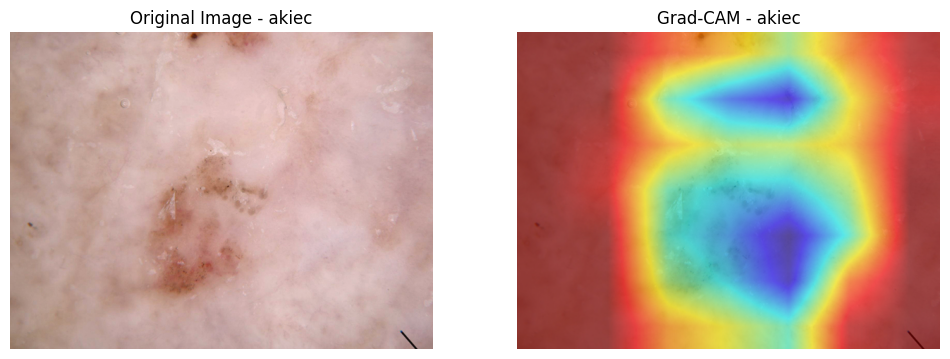

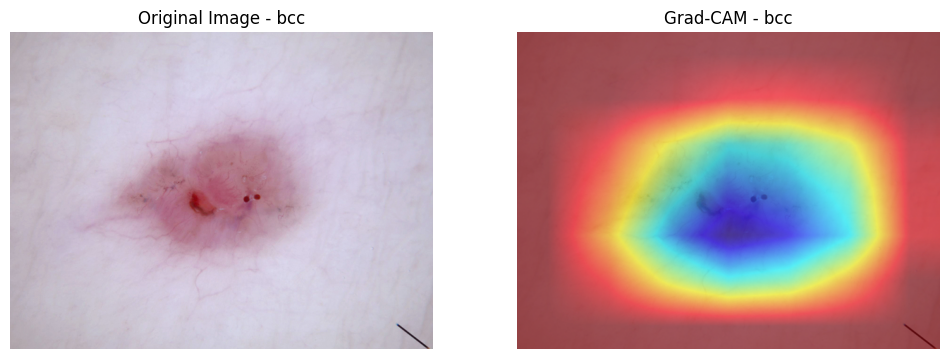

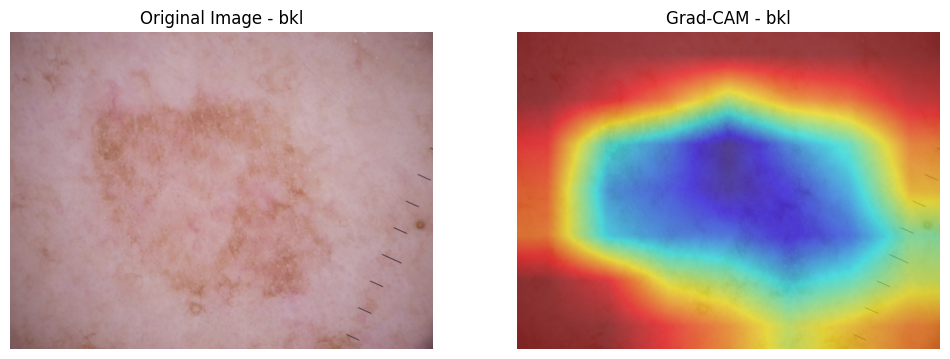

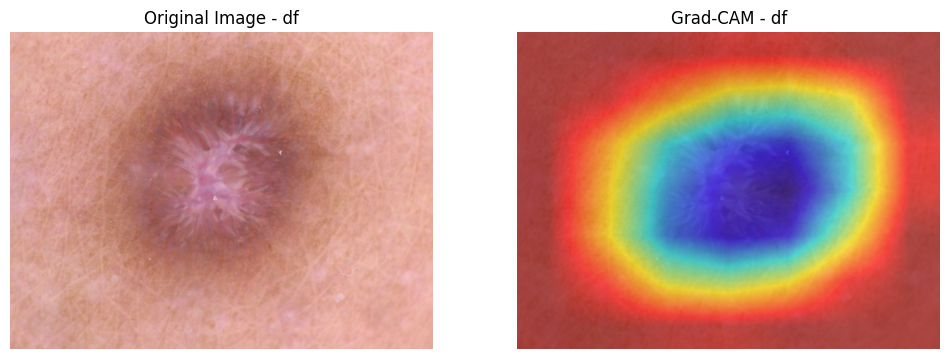

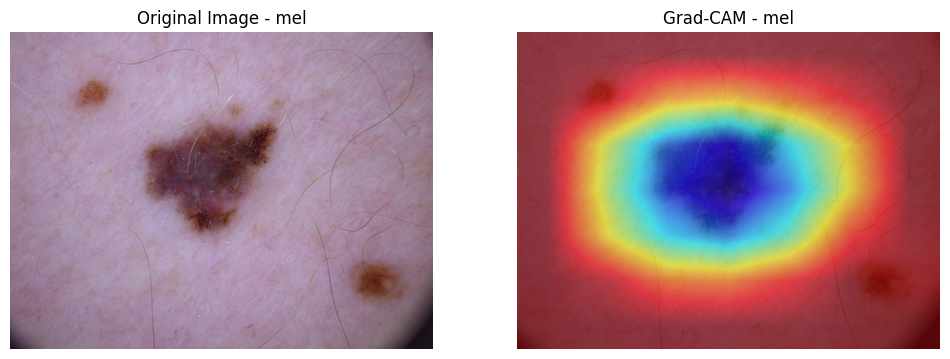

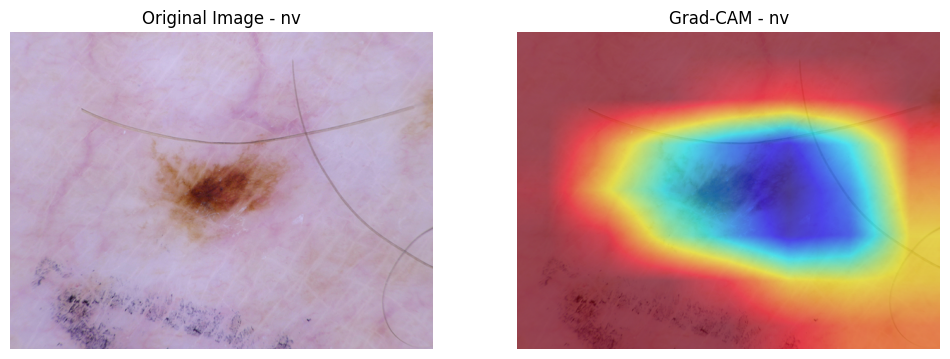

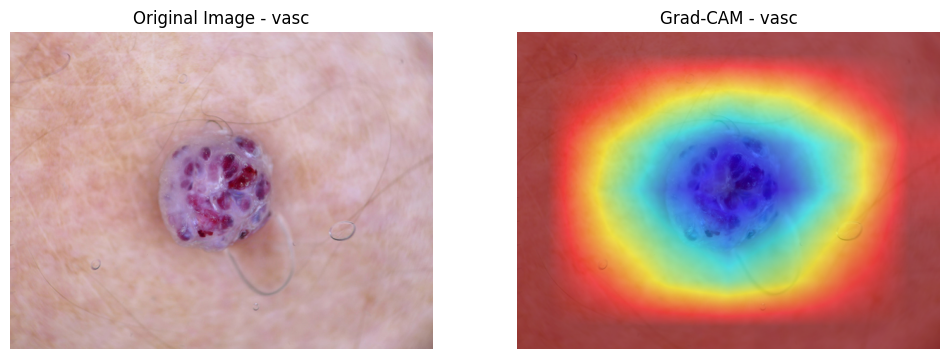

In [35]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

image_paths = [
    "/content/formatted_skin_cancer_data/val/akiec/ISIC_0024329.jpg",
    "/content/formatted_skin_cancer_data/val/bcc/ISIC_0024436.jpg",
    "/content/formatted_skin_cancer_data/val/bkl/ISIC_0024338.jpg",
    '/content/formatted_skin_cancer_data/val/df/ISIC_0024318.jpg',
    '/content/formatted_skin_cancer_data/val/mel/ISIC_0024315.jpg',
    '/content/formatted_skin_cancer_data/val/nv/ISIC_0024314.jpg',
    '/content/formatted_skin_cancer_data/val/vasc/ISIC_0024904.jpg'
]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for path in image_paths:
    img = Image.open(path).convert('RGB')
    input_img = transform(img).unsqueeze(0).to(device)

    class_idx = None
    heatmap = gradcam.generate_heatmap(input_img, class_idx)

    original_image, heatmap_overlay = gradcam.overlay_heatmap(heatmap, path)
    class_label = os.path.basename(os.path.dirname(path))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f'Original Image - {class_label}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_overlay)
    plt.title(f'Grad-CAM - {class_label}')
    plt.axis('off')
    plt.show()
